In [1]:
import torch  
import torchvision
from torchvision import transforms
import numpy as np  
import random  
from matplotlib import pyplot as plt  
import os  
import shutil
import torch.nn as nn 
import time  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 启用CUDA加速

In [2]:
def draw(acc1, acc2, loss1, loss2):
    x = range(len(acc1))
    # 创建一个1行2列的图像布局
    plt.figure(figsize=(8, 3))
    # 画图函数
    plt.subplot(1, 2, 1)
    plt.plot(x, acc1, label="train")
    plt.plot(x, acc2, color='r', label="test")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss1, label="train")
    plt.plot(x, loss2, color='r', label="test")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
def reset(folders):
    for folder in folders:
        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            if os.path.isfile(filepath) or os.path.islink(filepath):
                os.unlink(filepath)
            elif os.path.isdir(filepath):
                shutil.rmtree(filepath)

# 重置训练集和测试集
folders = ['./cardata/train/car', 
           './cardata/train/bus', 
           './cardata/train/truck',
           './cardata/test/car', 
           './cardata/test/bus', 
           './cardata/test/truck']

# 划分数据集函数
def makedata():
    random.seed(0)
    datapath = os.path.join(os.getcwd(), "cardata")
    traindata = os.path.join(datapath, "train")
    testdata = os.path.join(datapath, "test")
    types = ['car', 'bus', 'truck']
    for t in types:
        tpath = os.path.join(datapath, t)
        images = os.listdir(tpath)
        num = len(images)
        testimg = random.sample(images, k=int(num * 0.25)) # 25%做测试集
        for _, img in enumerate(images):
            if img in testimg:
                # 制作测试集
                imgpath = os.path.join(tpath, img)
                topath = os.path.join(testdata, t)
                shutil.copy(imgpath, topath)
            else:
                # 制作训练集
                imgpath = os.path.join(tpath, img)
                topath = os.path.join(traindata, t)
                shutil.copy(imgpath, topath)

In [4]:
reset(folders)
makedata()
data_transform = {"train": transforms.Compose([transforms.Resize((64 ,64)), # 拉伸到统一大小
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]),
                  "test": transforms.Compose([transforms.Resize((64, 64)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])}

batch_size = 128
train_dataset = torchvision.datasets.ImageFolder(root = os.path.join(os.getcwd(), "cardata/train"), transform = data_transform["train"])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 8)
test_dataset = torchvision.datasets.ImageFolder(root = os.path.join(os.getcwd(), "cardata/test"), transform = data_transform["test"])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers = 8)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        # 正常卷积部分，堆叠了两层卷积
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, 
                      kernel_size=3, stride=stride,
                      padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, 
                      kernel_size=3, stride=1, 
                      padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True)
        )
        

    def forward(self, x):
        out = self.left(x)
        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, ResidualBlock):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, 3)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.functional.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [7]:
def train_epoch(net, data_loader, device):
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0 
    correct = 0 
    sample_num = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        prediction = torch.argmax(output, 1)
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

In [8]:
def test_epoch(net, data_loader, device):
    net.eval() 
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0  
    sample_num = 0
    # 不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

Epoch 1: train: loss 1.059545 acc 0.568204; test: loss 90215.476562, acc 0.573964
Epoch 2: train: loss 0.719876 acc 0.716389; test: loss 1597.878717, acc 0.263314
Epoch 3: train: loss 0.629673 acc 0.769382; test: loss 57.353051, acc 0.597633
Epoch 4: train: loss 0.544918 acc 0.788027; test: loss 1.416078, acc 0.662722
Epoch 5: train: loss 0.557035 acc 0.785083; test: loss 0.838800, acc 0.748521
Epoch 6: train: loss 0.506845 acc 0.803729; test: loss 0.873455, acc 0.724852
Epoch 7: train: loss 0.511993 acc 0.804711; test: loss 0.838333, acc 0.736686
Epoch 8: train: loss 0.476958 acc 0.813543; test: loss 2.247386, acc 0.346154
Epoch 9: train: loss 0.443263 acc 0.828263; test: loss 1.842752, acc 0.500000
Epoch 10: train: loss 0.420646 acc 0.830226; test: loss 3.145608, acc 0.505917
Epoch 11: train: loss 0.393121 acc 0.842983; test: loss 1.738670, acc 0.707101
Epoch 12: train: loss 0.401033 acc 0.855741; test: loss 1.355173, acc 0.683432
Epoch 13: train: loss 0.390248 acc 0.842002; test: lo

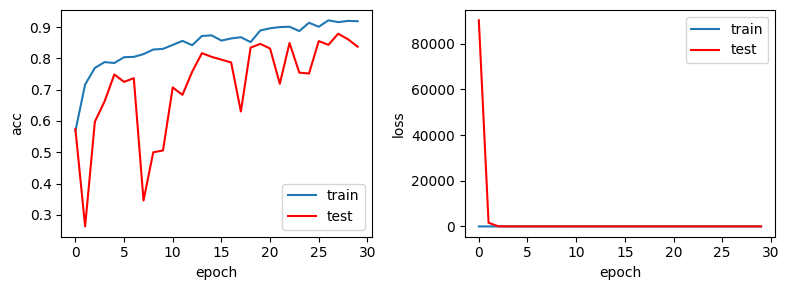

In [9]:
# 模型初始化
lr = 0.01
epochs = 30
net = ResNet(ResidualBlock).to(device)
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(net.parameters(),lr = lr)   

# 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
timestart = time.time()
# 进行训练
for epoch in range(epochs):
    print('Epoch %d: '%(epoch+1), end="")
    train_loss, train_acc = train_epoch(net, train_loader, device)
    print('train: loss %.6f acc %.6f; '%(train_loss, train_acc), end="")
    test_loss, test_acc = test_epoch(net, test_loader, device)
    print('test: loss %.6f, acc %.6f'%(test_loss, test_acc))
    # 保存各个指标
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
spendtime = (time.time() - timestart)  
print('Spend time: %.3f'%(spendtime))
draw(train_acc_list, test_acc_list, train_loss_list, test_loss_list)